# Running an example simulation
It's all very simple, mostly because this is a simple simulation. 
First, let's import stuff we'll need later on:

In [1]:
import numpy as np

from pandemic_sim.simulation import Person, Simulation
from pandemic_sim.geometries import RectangleGeometry
from pandemic_sim.health_systems import SimpleHealthSystem
from pandemic_sim.particle_engines import (DefaultParticleEngine,
                                           VelocityVerletIntegrator)
from pandemic_sim.transmission_models import DefaultTransmissionModel
from pandemic_sim.disease_models import DefaultPersonalDiseaseModel
from pandemic_sim.visualizations import (DefaultVisualization,
                                         DefaultPersonsDrawer,
                                         RectangleGeometryDrawer,
                                         SimpleHealthSystemCurvesPlotter)
from pandemic_sim.animators import CelluloidAnimator

- `Person` is class representing a person with attributes such as position in the room, infection status and whether the person is dead or alive
- `RectangleGeometry` represents a rectangular room and implements the force the walls exert on persons
- `Simulation` is the class containing the actual simulation code
- `SimpleHealthSystem` models the influence of the health system on the probability of a person dying during their infection. Setting a threshold and a death rate factor, you can emulate the limited ICU bed capacity.
- `DefaultParticleEngine` is a class which performs the purely physics part of the simulation, meaning the movement of persons and the forces acting between them. It does that with the help of the `VelocityVerletIntegration` class, which numerically integrates equations of motion
- `DefaultTransmissionModel` is a disease transmission model based on probabilities for exposing other people and for being susceptible
- `DefaultPersonalDiseaseModel` is a model which, for a single person, determines how likely that person is to die or to be cured from the disease in given simulation time step
- in `DefaultVisualization` is the... well... default visualization. It shows all persons as solid circles and additionally plots the timeline of infected and immune persons and fatalities
- `RectangeGeometryDrawer`, `DefaultPersonsDrawer`, `SimpleHealthSystemCurvesPlotter`: classes in which the drawing / plotting of different things is implemented
- `CelluloidAnimator` contains code to animate a visualization using the [`celluloid` package](https://github.com/jwkvam/celluloid)

If you want to change any of these components, the object-oriented design should make it relatively easy to, e.g., implement a new visualization. The visualization and animation code is currently not documented, though.

Preamble done, so let's start setting up our simulation:

In [5]:
n_persons = 200
room = RectangleGeometry(25, 25)
transmission_model = DefaultTransmissionModel(prob_dist=lambda d: d < 1)
# persons start with random positions and velocities
initial_positions = room.get_random_position_set(n_persons)
persons = [Person(pos=pos,
                  vel=np.random.uniform(low=(-2, -2), 
                                        high=(2, 2)),
                  personal_disease_model=None, personal_transmission_model=None,
                  infected=False, immune=False)
           for pos in initial_positions]
for p in persons:
    p.personal_transmission_model = transmission_model.personal_tm_factory(
        p, in_prob=1.0, out_prob=0.05)
    p.personal_disease_model = DefaultPersonalDiseaseModel(p, death_probability=0.00015, time_to_heal=150)

So we're going to have 200 persons moving around in a room with width 25 and height 25 (arbitrary units). The transmission model has an argument `prob_dist` which is a base probability for transmission to occur and which depends on the distance between persons. `death_prob` is the probability for an infected person to die in one unit of simulation time. The person-specific transmission model takes a probability for being susceptible (`in_prob`) and a probability for exposing others (`out_prob`). The latter is rather low, simulating the effect of a simple tissue face mask. `time_to_heal` is the number of simulation time units it takes for an infected person to get cured (and thus become immune)
Now we want some random persons to start out infected:

In [6]:
chosen_ones = np.random.choice(np.arange(n_persons), n_persons // 50)
for i in chosen_ones:
    persons[i].infected = True

Sorry, guys.  
On to setting up the simulation object:

In [7]:
health_system = SimpleHealthSystem(threshold=50, death_probability_factor=5.0)
pe = DefaultParticleEngine(cutoff=0.75, geometry_gradient=room.gradient,
                           integrator_params={'timestep': 0.1},
                           integrator_class=VelocityVerletIntegrator,
                           inter_particle_force_constant=20.0,
                           geometry_force_constant=20.0)
sim = Simulation(room, persons, health_system, transmission_model, particle_engine=pe)

The parameters with which the health system object is initialized mean that as soon as more than 150 persons are infected, the probability of a person dying in a time step is increased by a factor of three.  
As for the simulaton object: lots of parameters here:
- `timestep`: the time step for the integration scheme, which approximately solves the equations of motions for persons. The smaller that parameter is, the more accurate and detailed the simulated movement, but the longer the simulation takes to cover some predefined time span
- `cutoff`: distance at which the repulsive force between two persons (which makes them bounce off each other) kicks in
- `inter_particle_force_constant`: determines how hard two people bounce off each other. If this were set to zero, they could just pass through each other unhindered
- `geometry_force_constant`: determines how hard persons bounce off walls

Now we can run the simulation for some number `n_steps`:

In [8]:
n_steps = 500
simulation_results = sim.run(n_steps)

Simulating step 0/500...
Simulating step 50/500...
Simulating step 100/500...
Simulating step 150/500...
Simulating step 200/500...
Simulating step 250/500...
Simulating step 300/500...
Simulating step 350/500...
Simulating step 400/500...
Simulating step 450/500...
Done.


Done? Amazing. Let's use the above-discussed `DefaultVisualization` and the `CelluloidAnimator` to get a `.mp4` file with the animated simulation results:

Animating step 0/500...
Animating step 50/500...
Animating step 100/500...
Animating step 150/500...
Animating step 200/500...
Animating step 250/500...
Animating step 300/500...
Animating step 350/500...
Animating step 400/500...
Animating step 450/500...
Done.


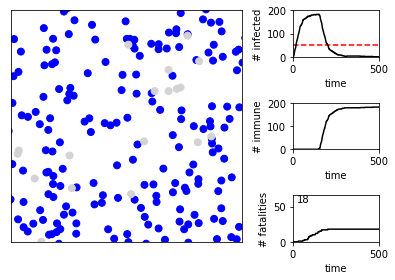

In [9]:
radius = pe.cutoff / 2
viz = DefaultVisualization(simulation_results, RectangleGeometryDrawer(room),
                           DefaultPersonsDrawer(radius), SimpleHealthSystemCurvesPlotter(health_system))
animator = CelluloidAnimator(viz, out="output.mp4", frame_rate=20)
animator.animate(n_steps, interval=2)

The `radius` determines the radius of the circles representing the persons. You want to set this to `pe.cutoff / 2`, otherwise things will look weird (persons might not touch or overlap too much). The dashed red line in the "# infected" plot is the health system threshold.
Animating takes quite a while, too; comparable to the time it takes to run the simulation itself. In the animation, blue dots represent healthy persons, orange dot infected persons, and gray dots dead persons.  
Let's view the results:

In [7]:
from IPython.display import Video
Video("output.mp4")

That's it&mdash;enjoy playing around with the parameters and the code and if you have suggestions on how to improve all this, feel free to open an issue and / or a pull request!